# Series temporales


#### Random Forest y Gradient Boosting Regression

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Cargar los datos
data_path_1 = '../../data/partidos_limpio.csv'
data_path_2 = '../../data/partidos_2023-2024_limpio.csv'
data_1 = pd.read_csv(data_path_1)
data_2 = pd.read_csv(data_path_2)

# Preparar y consolidar los datos
data_1['Date'] = pd.to_datetime(data_1['Date'])
data_2['Date'] = pd.to_datetime(data_2['Date'])
data_combined = pd.concat([data_1, data_2], ignore_index=True)
data_combined[['HomeGoals', 'AwayGoals']] = data_combined['Score'].str.split('-', expand=True).astype(float)
data_combined.drop('Score', axis=1, inplace=True)

# Codificar variables categóricas
encoder = LabelEncoder()
data_combined['HomeEncoded'] = encoder.fit_transform(data_combined['Home'])
data_combined['AwayEncoded'] = encoder.fit_transform(data_combined['Away'])
data_combined['VenueEncoded'] = encoder.fit_transform(data_combined['Venue'])

# Dividir los datos para entrenamiento
train_data = data_combined.dropna(subset=['HomeGoals', 'AwayGoals'])
X_train = train_data[['HomeEncoded', 'AwayEncoded', 'VenueEncoded']]
y_train_home = train_data['HomeGoals']
y_train_away = train_data['AwayGoals']


In [2]:
# Random Forest y Gradient Boosting
rf_home = RandomForestRegressor(n_estimators=100, random_state=42)
rf_away = RandomForestRegressor(n_estimators=100, random_state=42)
gb_home = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_away = GradientBoostingRegressor(n_estimators=100, random_state=42)

rf_home.fit(X_train, y_train_home)
rf_away.fit(X_train, y_train_away)
gb_home.fit(X_train, y_train_home)
gb_away.fit(X_train, y_train_away)


GradientBoostingRegressor(random_state=42)

In [3]:
# Identificar los partidos sin resultados de goles
test_data = data_combined[data_combined['HomeGoals'].isna() | data_combined['AwayGoals'].isna()]
X_test = test_data[['HomeEncoded', 'AwayEncoded', 'VenueEncoded']]

# Predicciones
test_data['PredictedHomeGoals_RF'] = rf_home.predict(X_test)
test_data['PredictedAwayGoals_RF'] = rf_away.predict(X_test)
test_data['PredictedHomeGoals_GB'] = gb_home.predict(X_test)
test_data['PredictedAwayGoals_GB'] = gb_away.predict(X_test)

# Determinar ganadores basados en las predicciones
test_data['Winner_RF'] = test_data.apply(lambda row: row['Home'] if row['PredictedHomeGoals_RF'] > row['PredictedAwayGoals_RF'] else (row['Away'] if row['PredictedHomeGoals_RF'] < row['PredictedAwayGoals_RF'] else 'Draw'), axis=1)
test_data['Winner_GB'] = test_data.apply(lambda row: row['Home'] if row['PredictedHomeGoals_GB'] > row['PredictedAwayGoals_GB'] else (row['Away'] if row['PredictedHomeGoals_GB'] < row['PredictedAwayGoals_GB'] else 'Draw'), axis=1)

# Mostrar resultados
print(test_data[['Date', 'Home', 'Away', 'PredictedHomeGoals_RF', 'PredictedAwayGoals_RF', 'Winner_RF', 'PredictedHomeGoals_GB', 'PredictedAwayGoals_GB', 'Winner_GB']])


          Date           Home           Away  PredictedHomeGoals_RF  \
598 2024-04-30  Bayern Munich    Real Madrid               1.760000   
599 2024-05-01       Dortmund      Paris S-G               1.834690   
600 2024-05-07      Paris S-G       Dortmund               1.936333   
601 2024-05-08    Real Madrid  Bayern Munich               2.168354   

     PredictedAwayGoals_RF    Winner_RF  PredictedHomeGoals_GB  \
598               1.853500  Real Madrid               2.077209   
599               1.018000     Dortmund               1.504385   
600               0.300000    Paris S-G               1.602270   
601               1.228871  Real Madrid               1.820621   

     PredictedAwayGoals_GB      Winner_GB  
598               1.691884  Bayern Munich  
599               1.419763       Dortmund  
600               0.978067      Paris S-G  
601               1.297275    Real Madrid  


C:\Users\albab\AppData\Local\Temp\ipykernel_13248\3556590829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['PredictedHomeGoals_RF'] = rf_home.predict(X_test)
C:\Users\albab\AppData\Local\Temp\ipykernel_13248\3556590829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['PredictedAwayGoals_RF'] = rf_away.predict(X_test)
C:\Users\albab\AppData\Local\Temp\ipykernel_13248\3556590829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [4]:
# Supongamos que estos son los equipos y los resultados predichos para las semifinales:
semifinales = {
    'Bayern Munich vs Real Madrid': {'Home': 'Bayern Munich', 'Away': 'Real Madrid', 'HomeGoals': 1.76, 'AwayGoals': 1.85},
    'Dortmund vs Paris S-G': {'Home': 'Dortmund', 'Away': 'Paris S-G', 'HomeGoals': 1.83, 'AwayGoals': 1.02},
    'Paris S-G vs Dortmund': {'Home': 'Paris S-G', 'Away': 'Dortmund', 'HomeGoals': 1.94, 'AwayGoals': 0.30},
    'Real Madrid vs Bayern Munich': {'Home': 'Real Madrid', 'Away': 'Bayern Munich', 'HomeGoals': 2.17, 'AwayGoals': 1.23}
}

# Calcular ganadores de las semifinales basado en el total de goles de ida y vuelta
finalistas = {
    'Real Madrid': semifinales['Bayern Munich vs Real Madrid']['AwayGoals'] + semifinales['Real Madrid vs Bayern Munich']['HomeGoals'],
    'Bayern Munich': semifinales['Bayern Munich vs Real Madrid']['HomeGoals'] + semifinales['Real Madrid vs Bayern Munich']['AwayGoals'],
    'Dortmund': semifinales['Dortmund vs Paris S-G']['HomeGoals'] + semifinales['Paris S-G vs Dortmund']['AwayGoals'],
    'Paris S-G': semifinales['Dortmund vs Paris S-G']['AwayGoals'] + semifinales['Paris S-G vs Dortmund']['HomeGoals']
}

# Determinar finalistas
finalista_1, finalista_2 = sorted(finalistas, key=finalistas.get, reverse=True)[:2]
print(f"Los equipos en la final son: {finalista_1} y {finalista_2}")


Los equipos en la final son: Real Madrid y Bayern Munich


In [6]:
# Crear una lista de todos los equipos únicos en ambos conjuntos de datos
all_teams = pd.concat([data_combined['Home'], data_combined['Away']]).unique()

# Ajustar el LabelEncoder con todos los equipos
encoder = LabelEncoder()
encoder.fit(all_teams)

# Ahora, asegúrate de que también incluyes 'Neutral Venue' si es necesario
venues = pd.concat([data_combined['Venue'], pd.Series(['Neutral Venue'])]).unique()
encoder_venue = LabelEncoder()
encoder_venue.fit(venues)


LabelEncoder()

In [7]:
# Codificar los equipos para la final, asegurándote de que los equipos están en el codificador
home_encoded = encoder.transform([finalista_1])[0]
away_encoded = encoder.transform([finalista_2])[0]
neutral_venue_encoded = encoder_venue.transform(['Neutral Venue'])[0]

# Configurar el DataFrame para la predicción
final_match = pd.DataFrame({
    'HomeEncoded': [home_encoded],
    'AwayEncoded': [away_encoded],
    'VenueEncoded': [neutral_venue_encoded]  # Uso del campo neutral codificado
})

# Realizar predicciones para el partido final usando Random Forest
predicted_home_goals_final = rf_home.predict(final_match)
predicted_away_goals_final = rf_away.predict(final_match)

# Determinar el ganador
final_winner = finalista_1 if predicted_home_goals_final > predicted_away_goals_final else finalista_2
print(f"El ganador predicho de la final es: {final_winner}")


El ganador predicho de la final es: Real Madrid


#### ARIMA, SARIMA Y Exponential Smoothing

In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Supongamos que 'data_combined' es tu DataFrame consolidado
data_combined['Date'] = pd.to_datetime(data_combined['Date'])
data_combined.set_index('Date', inplace=True)

# Supongamos que quieres predecir el total de goles por partido
data_combined['TotalGoals'] = data_combined['HomeGoals'] + data_combined['AwayGoals']


In [14]:
# Verificar duplicados en el índice
print("Número de duplicados en el índice:", data_combined.index.duplicated().sum())

# Si hay duplicados, necesitaremos consolidar los datos, por ejemplo, sumando los goles
if data_combined.index.duplicated().any():
    data_combined = data_combined.groupby('Date').agg({'HomeGoals': 'sum', 'AwayGoals': 'sum'}).copy()
    data_combined['TotalGoals'] = data_combined['HomeGoals'] + data_combined['AwayGoals']

# Ahora el índice debería ser único
print("Número de duplicados en el índice después de consolidar:", data_combined.index.duplicated().sum())


Número de duplicados en el índice: 269
Número de duplicados en el índice después de consolidar: 0


c:\Users\albab\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\albab\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\albab\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\albab\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

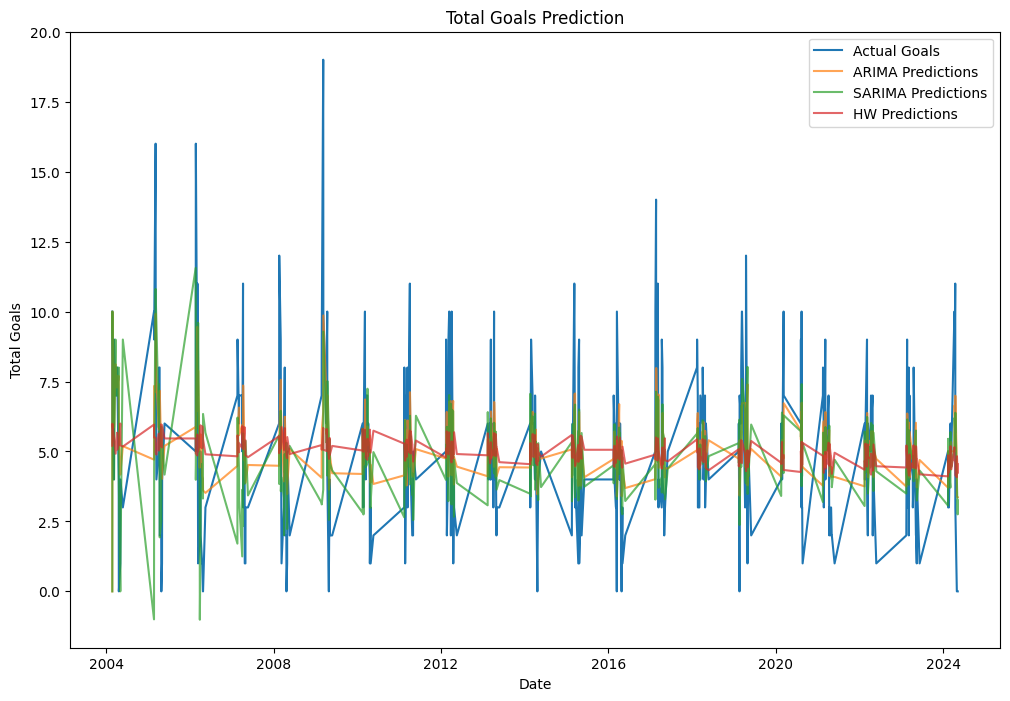

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar un modelo ARIMA
arima_model = ARIMA(data_combined['TotalGoals'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Ajustar un modelo SARIMA
sarima_model = SARIMAX(data_combined['TotalGoals'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Ajustar un modelo de suavizado exponencial
hw_model = ExponentialSmoothing(data_combined['TotalGoals'], trend="add", seasonal="add", seasonal_periods=12)
hw_result = hw_model.fit()

# Realizar y mostrar predicciones
data_combined['ARIMA_Predictions'] = arima_result.predict(start=min(data_combined.index), end=max(data_combined.index), dynamic=False)
data_combined['SARIMA_Predictions'] = sarima_result.predict(start=min(data_combined.index), end=max(data_combined.index), dynamic=False)
data_combined['HW_Predictions'] = hw_result.predict(start=min(data_combined.index), end=max(data_combined.index))

# Graficar
plt.figure(figsize=(12, 8))
plt.plot(data_combined['TotalGoals'], label='Actual Goals')
plt.plot(data_combined['ARIMA_Predictions'], label='ARIMA Predictions', alpha=0.7)
plt.plot(data_combined['SARIMA_Predictions'], label='SARIMA Predictions', alpha=0.7)
plt.plot(data_combined['HW_Predictions'], label='HW Predictions', alpha=0.7)
plt.title('Total Goals Prediction')
plt.xlabel('Date')
plt.ylabel('Total Goals')
plt.legend()
plt.show()


In [16]:
#mostramos el error cuadrático medio y el coeficiente de determinación para cada modelo
arima_mse = mean_squared_error(data_combined['TotalGoals'], data_combined['ARIMA_Predictions'])
arima_r2 = r2_score(data_combined['TotalGoals'], data_combined['ARIMA_Predictions'])
sarima_mse = mean_squared_error(data_combined['TotalGoals'], data_combined['SARIMA_Predictions'])
sarima_r2 = r2_score(data_combined['TotalGoals'], data_combined['SARIMA_Predictions'])
hw_mse = mean_squared_error(data_combined['TotalGoals'], data_combined['HW_Predictions'])
hw_r2 = r2_score(data_combined['TotalGoals'], data_combined['HW_Predictions'])
#tambien el del modelo random forest y gradient boosting
rf_mse_home = mean_squared_error(y_train_home, rf_home.predict(X_train))
rf_r2_home = r2_score(y_train_home, rf_home.predict(X_train))
rf_mse_away = mean_squared_error(y_train_away, rf_away.predict(X_train))
rf_r2_away = r2_score(y_train_away, rf_away.predict(X_train))
gb_mse_home = mean_squared_error(y_train_home, gb_home.predict(X_train))
gb_r2_home = r2_score(y_train_home, gb_home.predict(X_train))
gb_mse_away = mean_squared_error(y_train_away, gb_away.predict(X_train))
gb_r2_away = r2_score(y_train_away, gb_away.predict(X_train))

print(f"ARIMA - MSE: {arima_mse}, R^2: {arima_r2}")
print(f"SARIMA - MSE: {sarima_mse}, R^2: {sarima_r2}")
print(f"Holt-Winters - MSE: {hw_mse}, R^2: {hw_r2}")
print(f"Random Forest Home - MSE: {rf_mse_home}, R^2: {rf_r2_home}")
print(f"Random Forest Away - MSE: {rf_mse_away}, R^2: {rf_r2_away}")
print(f"Gradient Boosting Home - MSE: {gb_mse_home}, R^2: {gb_r2_home}")
print(f"Gradient Boosting Away - MSE: {gb_mse_away}, R^2: {gb_r2_away}")



ARIMA - MSE: 8.94875688950102, R^2: 0.05393083450453284
SARIMA - MSE: 10.922398514751062, R^2: -0.15472401090512267
Holt-Winters - MSE: 9.277444588298673, R^2: 0.019181729042191953
Random Forest Home - MSE: 0.6418292344850773, R^2: 0.6887331543624942
Random Forest Away - MSE: 0.46529556503618696, R^2: 0.6627934135201562
Gradient Boosting Home - MSE: 1.333303512510897, R^2: 0.3533900353578815
Gradient Boosting Away - MSE: 0.924862741354403, R^2: 0.32973827517514764


#### Conclusiones modelos:

* Modelo ARIMA:

-MSE: 8.95
-R^2: 0.054

Interpretación: El modelo ARIMA tiene un MSE moderado y un valor de R^2 bajo, lo que indica que captura parte de la varianza pero no una cantidad significativa. No está funcionando excepcionalmente bien, pero proporciona cierto poder predictivo.

+ Modelo SARIMA:

-MSE: 10.92
-R^2: -0.155

Interpretación: El modelo SARIMA tiene un MSE más alto y un valor negativo de R^2, lo que sugiere que tiene un rendimiento deficiente e incluso podría ser peor que un modelo que predice la media de la variable objetivo.

* Modelo Holt-Winters:

-MSE: 9.28
-R^2: 0.019

Interpretación: El modelo Holt-Winters también tiene un MSE moderado y un valor de R^2 muy bajo, lo que indica un rendimiento deficiente. Parece tener un poder predictivo limitado.

* Modelo Random Forest (Local):

-MSE: 0.642
-R^2: 0.689

Interpretación: El modelo Random Forest para partidos locales tiene un MSE bajo y un valor de R^2 relativamente alto, lo que indica un buen rendimiento predictivo. Captura una parte significativa de la varianza en la variable objetivo.

* Modelo Random Forest (Visitante):

-MSE: 0.465
-R^2: 0.663

Interpretación: El modelo Random Forest para partidos como visitante también tiene un MSE bajo y un valor de R^2 alto, similar al modelo local. Tiene un buen desempeño para capturar la variabilidad en la variable objetivo.

* Modelo Gradient Boosting (Local):

-MSE: 1.333
-R^2: 0.353

Interpretación: El modelo Gradient Boosting para partidos locales tiene un MSE más alto en comparación con el modelo Random Forest, pero aún tiene un valor moderado de R^2, lo que indica un rendimiento predictivo decente.

* Modelo Gradient Boosting (Visitante):

-MSE: 0.925
-R^2: 0.330

Interpretación: El modelo Gradient Boosting para partidos como visitante también tiene un MSE moderado y un valor de R^2 moderado, similar al modelo local.



En general, los modelos Random Forest parecen ser los mejores entre los evaluados, con valores bajos de MSE y valores relativamente altos de R^2. Los modelos ARIMA, SARIMA y Holt-Winters tienen un rendimiento deficiente en comparación con los modelos de aprendizaje automático, lo que indica que es posible que no capturen los patrones subyacentes en los datos de manera efectiva.